In [287]:
import pandas as pd
import jax.numpy as jnp
import jax
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Carregando o dataset wine diretamente do scikit-learn
from sklearn.datasets import load_wine
data, target = load_wine(return_X_y=True, as_frame=True)

eval_dict = {
    'Accuracy' : accuracy_score,
    'MC Coef' : matthews_corrcoef,
    'Confusion Matrix' : confusion_matrix,
    'F1 Score' : f1_score,
    'Recall' : recall_score,
}

j_data = jnp.array(data.values)
print(data.shape)

data.head()

(178, 13)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [288]:
def get_metrics(preds, ytest, eval_metrics):
    '''
    Get statistics given metrics comparing ytest and preds
    '''
    results = {}

    for m_name, m_foo in eval_metrics.items():
        if m_name in ['F1 Score', 'Recall'] :
            results[m_name] = m_foo(ytest, preds, average='micro')
        else:
            results[m_name] = m_foo(ytest, preds)

    return results

def show_results(results, title=None):
    
    '''Plots results line by line'''

    for m_name, m_value in results.items():

        if m_name == 'Confusion Matrix': 

            sns.heatmap(m_value, annot=True, fmt="d", cmap="Blues", cbar=True, 
                xticklabels=["Class 0", "Class 1", "Class 2"], 
                yticklabels=["Class 0", "Class 1", "Class 2"])
            plt.title(title)

        else:
            print(f'{m_name} : {m_value:.4f}')


In [289]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.4, random_state=166003)

compact_data = (x_train, x_test, y_train, y_test)

jx_train, jx_test, jy_train, jy_test = jnp.array(x_train), jnp.array(x_test) , jnp.array(y_train), jnp.array(y_test)

x_train.shape, x_test.shape, y_train.shape, y_test.shape


((106, 13), (72, 13), (106,), (72,))

In [290]:
def run_sklearn_benchmark(data, eval_metrics, k=5, metric='minkowski'): 
    '''Runs a sklearn based-KNN and evaluates it '''

    x_train, x_test, y_train, y_test = data

    knn_benchmark = KNeighborsClassifier(n_neighbors=k, metric=metric)

    knn_benchmark.fit(x_train, y_train)

    y_pred = knn_benchmark.predict(x_test)

    results = get_metrics(y_pred, y_test, eval_metrics)

    return results



### Defining a distance function

Given any dot product  $<. \hspace{5px},\hspace{5px} .>$ this distance between two vectors X, Y is equal to :

$$ d(X,Y) =  ||X, Y || = (<X- Y,X - Y>)^\frac{1}{2}$$



In [291]:
def r2_inner_product(a, b):
    # inner product implemented at the book (eq 3.9)
    return a[0] * b[0] -(a[0] * b[1] + a[1] * b[0]) +  2 * a[1] * b[1]


def generic_distance(x, y, inner_product=jnp.dot):
    return jnp.sqrt(inner_product(x - y, x - y))


def batch_generic_distance(X, Y, inner_product = jnp.dot):
    '''
    calculates the distance matrix for two N, M arrays using 
    the generic inner product concept
    '''
    def __one_vector_to_Nvector(xi, vec, inner_product):

        return jax.vmap(lambda yi : generic_distance(xi, yi, inner_product))(vec)
    
    d_matrix = jax.vmap(lambda xi : __one_vector_to_Nvector(xi, Y, inner_product))(X)

    return d_matrix

In [292]:
def jax_knn(x_train, x_test, y_train, y_test, k=5, metric=jnp.dot):
    '''
    Classifies x_test given the train set using a KNN algorithm with JAX pipeline
    '''

    def __get_labels(n_labels):
        return jnp.argmax(jnp.bincount(n_labels, length=k))

    def get_labels_2d(label_neighbors):
        return jax.vmap(__get_labels)(label_neighbors)
   

    d_matrix = batch_generic_distance(x_test, x_train, inner_product=metric)
    inx = jnp.argsort(d_matrix)[:, :k]
    n_labels = y_train[inx]
    y_pred = get_labels_2d(n_labels)
    return y_pred


Accuracy : 0.8194
MC Coef : 0.7274
F1 Score : 0.8194
Recall : 0.8194


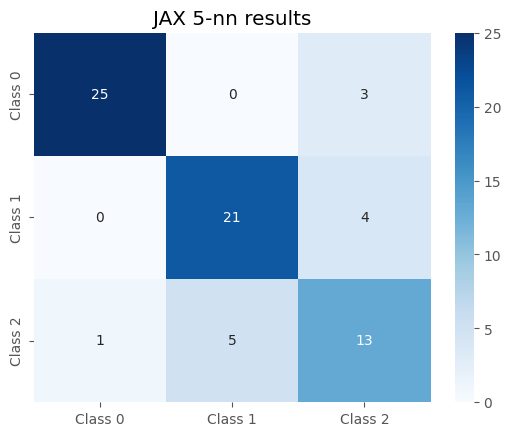

In [293]:
K = 5
jy_preds = jax_knn(jx_train, jx_test, jy_train, jy_test, K, jnp.dot)
jax_knn_metrics = get_metrics(jy_preds, jy_test, eval_dict )
show_results(jax_knn_metrics, f'JAX {K}-nn results')

### Comparison with sklearn solution

Accuracy : 0.8194
MC Coef : 0.7274
F1 Score : 0.8194
Recall : 0.8194


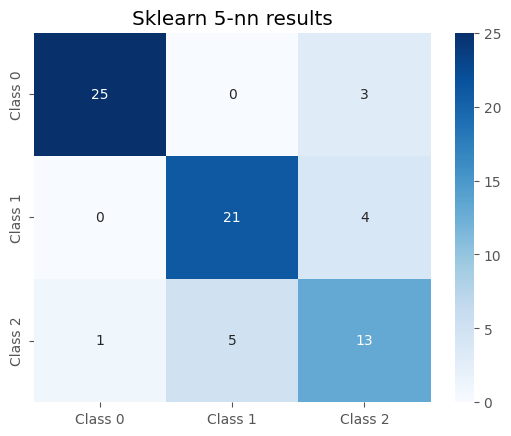

In [294]:
results = run_sklearn_benchmark(compact_data, eval_dict, K)
show_results(results, f'Sklearn {K}-nn results')

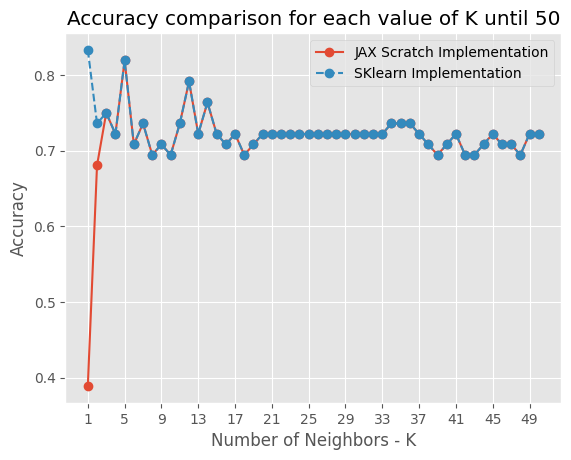

In [295]:
def get_accuracy_per_K(jx_train, jx_test, jy_train, jy_test, compact_data, k_max_range):
    '''
    Runs for both JAX and SKlearn, each K in the range [1-k_max_range]
    '''

    jax_list = []
    sklearn_list = []
    for n_number in range(1, k_max_range):
        jy_preds = jax_knn(jx_train, jx_test, jy_train, jy_test, n_number, jnp.dot)

        sklearn_metrics = run_sklearn_benchmark(compact_data, eval_dict, n_number)
        jax_knn_metrics = get_metrics(jy_preds, jy_test, eval_dict)

        jax_list.append(jax_knn_metrics['Accuracy'])
        sklearn_list.append(sklearn_metrics['Accuracy'])

    return jax_list, sklearn_list

jax_metrics, sklearn_metrics = get_accuracy_per_K(jx_train, jx_test, jy_train, jy_test, compact_data, 51)

plt.title("Accuracy comparison for each value of K until 50")

plt.xticks(ticks=np.arange(0, 50, 4), labels=np.arange(1, 52, 4))
plt.plot(jax_metrics, label='JAX Scratch Implementation', marker='o')
plt.plot(sklearn_metrics, label='SKlearn Implementation', linestyle='--', marker='o')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors - K')
plt.show()


For K = 1, the from scratch jax model isnt competitive with the sklearn one, actually, with no model ever, since it just randomly guesses. This is probaly due to the algorithm that the Sklearn implementation uses to find the nearest neighbors is a more refined one, not as simple as using only the distance.

For values of K > 1, the JAX solution stops behaving randomly. And for K > 2, not only it shows signs of learning but also begins to show the same metrics as the KNN implemented on Sklearn lib (using the same distance definition). This effect was tested until K = 50, even though the test set size is 70-ish samples, this test was purely done to compare both implementations

## PCA

In [303]:
def jax_pca(data, n_components=5):
    '''
    Computes the Principal Component Decomposition with JAX numpy api
    '''
    n_features = data.shape[-1]
    _Xc = data - jnp.mean(data, axis=0)
    C = jnp.dot(_Xc.T, _Xc) / (n_features - 1)
    ei_values, ei_vectors = jnp.linalg.eigh(C) # note: matrix is hermetian, so foo its ok
    sorted_indexes = jnp.argsort(ei_values, descending=True)
    sorted_eigenvectors = ei_vectors[:, sorted_indexes]
    n_principal_eigenvectors = sorted_eigenvectors[:, :n_components]

    return jnp.dot(_Xc, n_principal_eigenvectors)


(178, 5)

In [332]:
N_COMPONENTS = 2
x_c = jax_pca(j_data, n_components=N_COMPONENTS)
x_pca = PCA(n_components=5).fit_transform(data.values)


jxpca_train, jxpca_test, y_train, y_test = train_test_split(x_c, target, test_size=0.4, random_state=166003)
xpca_train, xpca_test, ypca_train, ypca_test = train_test_split(x_pca, target, test_size=0.4, random_state=166003)

jy_train = jnp.array(y_train)
jy_test = jnp.array(y_test)

compact_pca_data = (xpca_train, xpca_test, ypca_train, ypca_test)

Homemade KNN and PCA
Accuracy : 0.7917
MC Coef : 0.6873
F1 Score : 0.7917
Recall : 0.7917


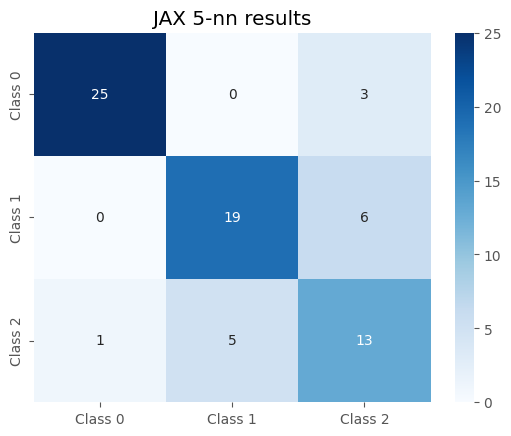

--------------------
Sklearn KNN and PCA
Accuracy : 0.8194
MC Coef : 0.7274
F1 Score : 0.8194
Recall : 0.8194


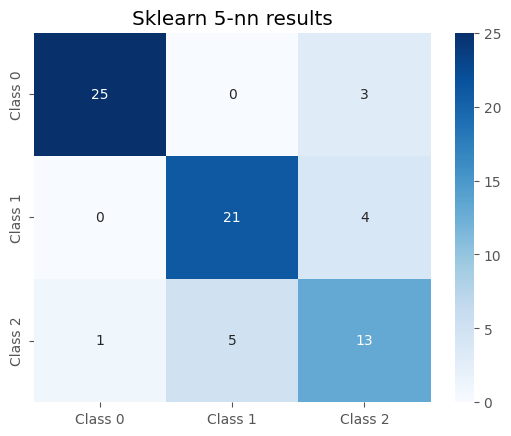

In [333]:
K = 5
jy_preds = jax_knn(jxpca_train, jxpca_test, jy_train, jy_test, K, jnp.dot)
jax_knn_metrics = get_metrics(jy_preds, jy_test, eval_dict)
print("Homemade KNN and PCA")
show_results(jax_knn_metrics, f'JAX {K}-nn results')
plt.show()
print("-" * 20)
print("Sklearn KNN and PCA")
results = run_sklearn_benchmark(compact_pca_data, eval_dict, K)
show_results(results, f'Sklearn {K}-nn results')

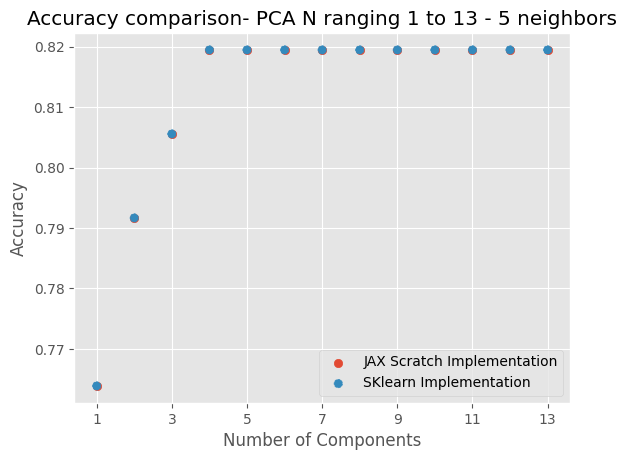

In [339]:
def get_accuracy_per_PCA_N(j_data, data, target, N_RANGE,K):
    '''
    Runs both JAX and Sklearn based KNN in the [1,N_RANGE] as components for the PCA using K neighbors
    '''

    jax_list = []
    sklearn_list = []
    for n_number in range(1, N_RANGE):
        x_c = jax_pca(j_data, n_number)
        x_pca = PCA(n_components=n_number).fit_transform(data.values, target)

        jxpca_train, jxpca_test, y_train, y_test = train_test_split(x_c, target, test_size=0.4, random_state=166003)
        compact_pca_data = train_test_split(x_pca, target, test_size=0.4, random_state=166003)

        jy_train = jnp.array(y_train)
        jy_test = jnp.array(y_test)

        jy_preds = jax_knn(jxpca_train, jxpca_test, jy_train, jy_test, K, jnp.dot)

        sklearn_metrics = run_sklearn_benchmark(compact_pca_data, eval_dict, K)
        jax_knn_metrics = get_metrics(jy_preds, jy_test, eval_dict)

        jax_list.append(jax_knn_metrics['Accuracy'])
        sklearn_list.append(sklearn_metrics['Accuracy'])

    return jax_list, sklearn_list

k_pca = 5
jax_list, sklearn_list = get_accuracy_per_PCA_N(j_data, data, target, 14, K = k_pca)

plt.title(f"Accuracy comparison- PCA N ranging 1 to 13 - {k_pca} neighbors")
plt.xticks(ticks=np.arange(0, 14, 2), labels=np.arange(1, 14,2))
plt.scatter(jnp.arange(len(jax_list)), jax_list, label='JAX Scratch Implementation', marker='o')
plt.scatter(jnp.arange(len(sklearn_list)), sklearn_list, label='SKlearn Implementation', linestyle='--', marker='o')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Number of Components')
plt.show()

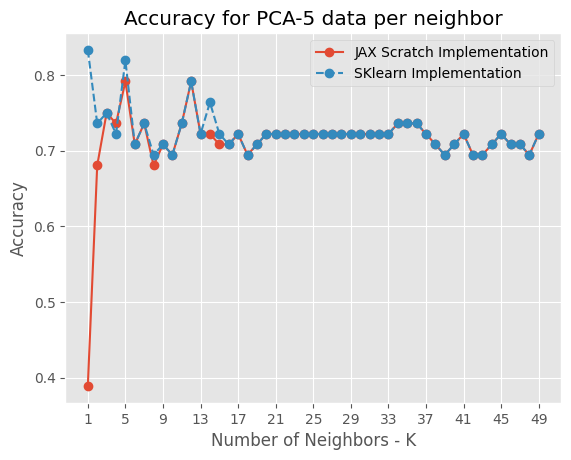

In [340]:
jax_pca_k, sklearn_pca_k = get_accuracy_per_K(jxpca_train, jxpca_test, jy_train, jy_test, compact_pca_data, 50)

plt.title("Accuracy for PCA-5 data per neighbor")
plt.xticks(ticks=np.arange(0, 50, 4), labels=np.arange(1, 52, 4))
plt.plot(jax_pca_k, label='JAX Scratch Implementation', marker='o')
plt.plot(sklearn_pca_k, label='SKlearn Implementation', linestyle='--', marker='o')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors - K')
plt.show()


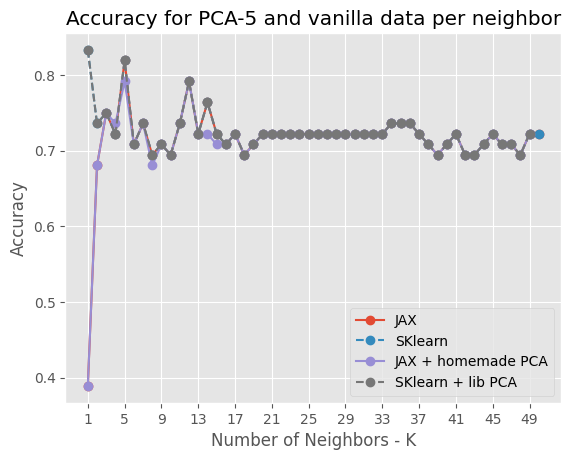

In [344]:
plt.title("Accuracy for PCA-5 and vanilla data per neighbor")

plt.xticks(ticks=np.arange(0, 50, 4), labels=np.arange(1, 52, 4))
plt.plot(jax_metrics, label='JAX', marker='o')
plt.plot(sklearn_metrics, label='SKlearn', linestyle='--', marker='o')
plt.plot(jax_pca_k, label='JAX + homemade PCA', marker='o')
plt.plot(sklearn_pca_k, label='SKlearn + lib PCA ', linestyle='--', marker='o')

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors - K')
plt.show()


Speed comparison - PCA  


In [356]:
%%timeit -n200
jy_preds = jax_knn(jxpca_train, jxpca_test, jy_train, jy_test, K, jnp.dot)


6.11 ms ± 696 µs per loop (mean ± std. dev. of 7 runs, 200 loops each)


In [357]:
%%timeit -n200
jy_preds = jax_knn(jx_train, jx_test, jy_train, jy_test, K, jnp.dot)

8.17 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 200 loops each)


In most cases, the data decomposition did not altered the KNN performance. Neither for the Sklearn implementation or the one proposed in this work. Given the figure above, its possible to verify, there is a slightly difference between the lilac and grey lines, which match to the implementations using the homemade PCA and the lib PCA.

With a more attentive reading, one can visualize that the curves have the same behavior regardless the usage of the decomposition technique. Also accounting for the accuracy comparison N-PCA components, its easy to notice a increasing performance when the number of components increase, even though it get capped around component number 4, which means the main four eigenvalues are enough to represent the data for this PCA/KNN setup. But in general as the performance dont have shown any increases in comparison with the base data, the PCA in this case can not be considered a technique to increase model`s accuracy.

Now regarding time to run, in the above cells, there are two comparisons, the plain JAX-KNN and the one with the PCA using 5 components. Considering this settings and the enviroment utilized, the PCA implementation were faster (removing the time to compute the principal components), unfortunally to retain compatibility with other internal products definition, the jax jit functions couldnt be applied
  

